In [1]:
import pandas as pd


In [2]:
# Generate common name for yeast proteins
temp_df = pd.read_table("./4932.protein.info.v11.5.txt",delimiter='\t')
common_name = dict(temp_df.iloc[:,:2].values)

In [3]:
# Read in preprocessed uniprot data
uniprot_df = pd.read_csv('uniprot_processed.csv')

In [4]:
# Read in essential node data
essential_df = pd.read_csv('essential.csv', header=None)

In [5]:
# import and setup
import networkx as nx

import numpy as np
import scipy as sp

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)

In [6]:
# Let's keep track of our studied proteins
studied_proteins = {
    'DIC1': '4932.YLR348C',
    'RGT2': '4932.YDL138W',
    'CBF5': '4932.YLR175W',
    'EST2': '4932.YLR318W'
}

In [7]:
# Read in dataframe for detailed protein links
G0_dataframe = pd.read_table("./4932.protein.links.detailed.v11.5.txt",delimiter=' ')

In [8]:
# Reweight edges of protein links
keep_columns = [
    'neighborhood', 'fusion', 'cooccurence', 
    'coexpression', 'experimental', 'database', 
    'textmining'
]

# Double weight of experimental evidence
G0_dataframe['experimental'] *= 2

# Half weight of textmining
G0_dataframe['textmining'] //=2

# Calculate combined score
G0_dataframe.combined_score = G0_dataframe[keep_columns].max(axis=1)

# Drop edges with combined score of zero
G0_dataframe = G0_dataframe.drop(G0_dataframe[G0_dataframe.combined_score == 0].index)

In [9]:
# Drop edges with combined score of <= threshold score
threshold_score = 600
G0_dataframe = G0_dataframe.drop(
    G0_dataframe[G0_dataframe.combined_score <= threshold_score].index
    )

In [10]:
# Sanity check of data

G0_dataframe

,protein1,protein2,neighborhood,fusion,cooccurence,coexpression,experimental,database,textmining,combined_score
67,4932.Q0045,4932.YML120C,0,0,0,0,0,900,55,900
71,4932.Q0045,4932.YOR257W,0,0,0,0,630,0,0,630
73,4932.Q0045,4932.YPL172C,155,0,370,499,630,0,419,630
75,4932.Q0045,4932.YGR033C,0,0,0,0,702,0,0,702
80,4932.Q0045,4932.YKL192C,0,0,0,49,1060,0,116,1060
...,...,...,...,...,...,...,...,...,...,...
1988527,4932.YPR203W,4932.YER189W,0,0,0,872,0,0,0,872
1988542,4932.YPR204W,4932.YPR018W,0,0,0,0,840,0,0,840
1988553,4932.YPR204W,4932.YBL032W,0,0,0,0,630,0,0,630
1988565,4932.YPR204W,4932.YNL255C,0,0,0,0,630,0,0,630


In [11]:
# Create nx graph

G0 = nx.from_pandas_edgelist(G0_dataframe, 
    source='protein1', 
    target='protein2', 
    edge_attr=True)

In [12]:
# Ignore certain nodes in the protein network, and also combine uniprot data

# remove proteins that are not in a location that we are targeting
# (we target membrane, mitochrondrial, cytoplasm and nucleus proteins)
irrelevant_proteins = []

# remove proteins that are ribosomal
ribosomal_proteins = []

row_index = {}

for node in G0.nodes:
    # Get row index of matching row for a protein
    node_name = node.split('.')[1]
    node_matches = uniprot_df['Gene Names'].str.contains(node_name).fillna(False)
    node_uniprot = uniprot_df.index[node_matches][0]

    if uniprot_df['location_match'][node_uniprot] == 0:
        irrelevant_proteins.append(node)

    elif uniprot_df['ribosomal'][node_uniprot] == True:
        ribosomal_proteins.append(node)

    else:
        row_index[node] = node_uniprot

print(f"{len(irrelevant_proteins)=}, {len(ribosomal_proteins)=}")
print(f"{len(G0.nodes)=}")
G0.remove_nodes_from(irrelevant_proteins)
G0.remove_nodes_from(ribosomal_proteins)
print(f"{len(G0.nodes)=}")

len(irrelevant_proteins)=1334, len(ribosomal_proteins)=312
len(G0.nodes)=5912
len(G0.nodes)=4266


In [13]:
# Track location of nodes
node_location = {}

mitochondrial_proteins = set()
cytoplasm_proteins = set()
membrane_proteins = set()
nucleus_proteins = set()

for node in G0.nodes:
    if uniprot_df['mitochon'][row_index[node]] == 1:
        node_location[node] = 'mitochondria'
        mitochondrial_proteins.add(node)
    elif uniprot_df['cytoplasm'][row_index[node]] == 1:
        node_location[node] = 'cytoplasm'
        cytoplasm_proteins.add(node)
    elif uniprot_df['membrane'][row_index[node]] == 1:
        node_location[node] = 'membrane'
        membrane_proteins.add(node)
    elif uniprot_df['nucleus'][row_index[node]] == 1:
        node_location[node] = 'nucleus'
        nucleus_proteins.add(node)
    else:
        node_location[node] = 'other'

nx.set_node_attributes(G0, values=node_location, name='location')

In [14]:
# We remove essential proteins, but keep proteins we want to study
essential_proteins_raw = essential_df[1].values
essential_proteins = set(map(lambda x: '4932.' + x, essential_proteins_raw))
essential_proteins -= set(studied_proteins.values())
print(f"{len(G0.nodes)=}")
G0.remove_nodes_from(list(essential_proteins))
print(f"{len(G0.nodes)=}")

len(G0.nodes)=4266
len(G0.nodes)=3271


In [15]:
# Let's only keep the largest connected component
largest_component = max(list(nx.connected_components(G0)), key=len)
G0 = G0.subgraph(largest_component)
print(f"{len(G0.nodes)=}")

len(G0.nodes)=3172


In [16]:
# Sanity check - 
#   Check proteins we are interested in are still in the network

for key, value in studied_proteins.items():
    if value not in G0.nodes:
        print(f"ERROR: {key} was deleted from the network!")

In [17]:
# Check statistics about clusters
def check_louvain(louvain_communities):
    num_clusters = len(louvain_communities)
    cluster_sizes = list(map(len, louvain_communities))
    print(f"{num_clusters=}, avg_size={sum(cluster_sizes)/num_clusters}")
    print(cluster_sizes)

In [18]:
# Perform louvain clustering
mitochondrial_communities = nx.algorithms.community.louvain_communities(
    G0.subgraph(mitochondrial_proteins), 
    resolution=2)
cytoplasm_communities = nx.algorithms.community.louvain_communities(
    G0.subgraph(cytoplasm_proteins), 
    resolution=2)
nucleus_communities = nx.algorithms.community.louvain_communities(
    G0.subgraph(nucleus_proteins), 
    resolution=2)
membrane_communities = nx.algorithms.community.louvain_communities(
    G0.subgraph(membrane_proteins), 
    resolution=1.5)

In [19]:
check_louvain(mitochondrial_communities)
check_louvain(cytoplasm_communities)
check_louvain(nucleus_communities)
check_louvain(membrane_communities)

num_clusters=62, avg_size=9.85483870967742
[1, 17, 22, 1, 1, 16, 1, 1, 12, 26, 1, 1, 15, 21, 1, 1, 36, 26, 51, 1, 1, 19, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 102, 15, 10, 1, 1, 1, 1, 27, 1, 1, 1, 1, 1, 5, 36, 1, 1, 1, 1, 1, 62, 21, 1, 11, 20, 1, 1, 1, 1]
num_clusters=78, avg_size=14.282051282051283
[1, 2, 1, 30, 1, 1, 52, 12, 1, 35, 1, 1, 1, 37, 1, 34, 1, 1, 1, 50, 44, 1, 15, 1, 1, 51, 1, 1, 1, 1, 1, 1, 31, 18, 25, 1, 33, 1, 32, 21, 51, 1, 1, 53, 1, 1, 1, 1, 26, 19, 1, 34, 56, 1, 22, 1, 1, 44, 24, 1, 1, 1, 1, 20, 1, 1, 1, 57, 20, 1, 1, 30, 1, 1, 39, 1, 51, 1]
num_clusters=35, avg_size=14.657142857142857
[1, 1, 18, 18, 21, 1, 51, 1, 59, 1, 1, 1, 70, 4, 1, 17, 2, 28, 27, 23, 23, 28, 2, 12, 16, 4, 1, 1, 1, 1, 1, 32, 18, 1, 26]
num_clusters=257, avg_size=3.6342412451361867
[3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 36, 1, 1, 1, 1, 1, 1, 1, 1, 32, 1, 1, 42, 1, 1, 1, 1, 49, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 15, 1, 32, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 17, 1, 38, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [20]:
# We check the size of the community with each studied protein
result_louvain = mitochondrial_communities + cytoplasm_communities \
    + nucleus_communities + membrane_communities

for protein in studied_proteins.values():
    community = tuple()
    for curr_community in result_louvain:
        if protein in curr_community:
            community = curr_community
            break
    print(len(community))


27
53
53
18


In [21]:
# From above, we are safe to remove all communities with only a single node
result_louvain = [comm for comm in result_louvain if len(comm) > 1]

In [22]:
check_louvain(result_louvain)

num_clusters=114, avg_size=25.035087719298247
[17, 22, 16, 12, 26, 15, 21, 36, 26, 51, 19, 102, 15, 10, 27, 5, 36, 62, 21, 11, 20, 2, 30, 52, 12, 35, 37, 34, 50, 44, 15, 51, 31, 18, 25, 33, 32, 21, 51, 53, 26, 19, 34, 56, 22, 44, 24, 20, 57, 20, 30, 39, 51, 18, 18, 21, 51, 59, 70, 4, 17, 2, 28, 27, 23, 23, 28, 2, 12, 16, 4, 32, 18, 26, 3, 2, 36, 32, 42, 49, 2, 15, 32, 2, 17, 38, 2, 17, 10, 2, 2, 2, 2, 2, 18, 2, 2, 53, 30, 2, 2, 2, 2, 16, 22, 34, 13, 2, 44, 81, 2, 29, 3, 49]


In [23]:
G2 = nx.DiGraph()
for community in result_louvain:
    G2.add_node(tuple(community))

node_to_community = {}
for i, community in enumerate(result_louvain):
    node_to_community.update(dict.fromkeys(community, i))


adjacency = [[0] * len(result_louvain) for _ in range(len(result_louvain))]

direction = {
    'mitochondria': {'cytoplasm', 'mitochondria'},
    'cytoplasm': {'nucleus', 'mitochondria', 'cytoplasm'},
    'nucleus': {'nucleus'},
    'membrane': {'mitochondria', 'membrane'}
}


for edge in G0.edges:
    if edge[0] in node_to_community and edge[1] in node_to_community:

        if G0.nodes[edge[1]]['location'] in direction[G0.nodes[edge[0]]['location']]:
            adjacency[node_to_community[edge[0]]][node_to_community[edge[1]]] += 1
        if G0.nodes[edge[0]]['location'] in direction[G0.nodes[edge[1]]['location']]:
            adjacency[node_to_community[edge[1]]][node_to_community[edge[0]]] += 1

for i in range(len(result_louvain)):
    for j in range(len(result_louvain)):
        if i != j and adjacency[i][j] > 0:
            G2.add_edge(tuple(result_louvain[i]), tuple(result_louvain[j]), 
                weight=adjacency[i][j]/(len(result_louvain[i]) + len(result_louvain[j])))
            # G2.add_edge(tuple(result_louvain[i]), tuple(result_louvain[j]), weight=adjacency[i][j])


In [24]:
community_to_index = {}
for i, community in enumerate(result_louvain):
    community_to_index[tuple(community)] = i

In [25]:
print(sum(adjacency[0])/len(adjacency[0]))

2.7280701754385963


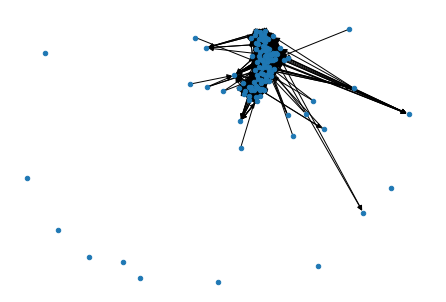

In [26]:
weights = [G2[u][v]['weight']/100 for u,v in G2.edges]
nx.draw(G2,node_size = 20, pos=nx.spring_layout(G2, weight='weight'))

In [27]:
studied_communities = {}
for key, value in studied_proteins.items():
    print(node_to_community[value])
    studied_communities[key] = tuple(result_louvain[node_to_community[value]])

14
97
39
72


In [28]:
# Setup for widest bottleneck path
import networkx.algorithms.shortest_paths as nx_path

class Widest_Add():
    def __init__(self, width):
        self.width = width
    def __add__(self, other):
        # maybe put a check that other has class Widest_Add. But shouldn't need.
        if isinstance(other, int):
            return Widest_Add(max(self.width, other))
        return Widest_Add(max(self.width, other.width))
    def __radd__(self, other):
        # maybe put a check that other has class Widest_Add. But shouldn't need.
        if isinstance(other, int):
            return Widest_Add(max(self.width, other))
        return Widest_Add(max(self.width, other.width)) 
    def __le__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width <= other.width
    def __lt__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width < other.width
    def __eq__(self, other):
        if isinstance(other, int):
            other = Widest_Add(other)
        return self.width == other.width

def widest_weight(node1, node2, datadict):
    return Widest_Add(1/datadict['weight'])

def widest_weight2(node1, node2, datadict):
    return Widest_Add(datadict['weight'])



In [29]:
def get_repr_candidate(prev, curr, next):
    candidates = set(curr)

    left = set()
    for node in prev:
        left |= set(G0[node])
    right = set()
    for node in next:
        right |= set(G0[node])
    return candidates & left & right

In [30]:
def get_representative_node(prev, curr, next):
    subgraph = G0.subgraph(list(prev) + list(curr) + list(next))
    betCent = nx.betweenness_centrality(subgraph, normalized=True, endpoints=True)

    comm_nodes = [(n, betCent[n]) for n in curr]
    comm_nodes.sort(key=lambda x: x[1], reverse=True)

    reps = get_repr_candidate(prev, curr, next)
    for node, _ in comm_nodes:
        if node in reps:
            print('hit', node)
            return node

    central_node = comm_nodes[0][0]
    print('miss', central_node)
    return central_node

In [31]:
def try_process_old(start, end):
    widest_path = nx_path.dijkstra_path(G2, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight)
    widest_path2 = nx_path.dijkstra_path(G2, 
        studied_communities[start], 
        studied_communities[end], 
        widest_weight2)
    # print(len(widest_path))
    widest_path_edges = []
    for i in range(len(widest_path) - 1):
        u,v = widest_path[i], widest_path[i+1]
        widest_path_edges.append((community_to_index[u], community_to_index[v], G2[u][v]['weight']))

    # print(len(widest_path2))
    widest_path_edges2 = []
    for i in range(len(widest_path2) - 1):
        u,v = widest_path2[i], widest_path2[i+1]
        widest_path_edges2.append((community_to_index[u], community_to_index[v], G2[u][v]['weight']))
    # print(widest_path_edges)
    # print(widest_path_edges2)

    centers = []
    path_elems = [[studied_proteins[start]]] + widest_path + [[studied_proteins[end]]]
    for i, community in enumerate(widest_path):
        c = get_representative_node(path_elems[i], community, path_elems[i+2])
        centers.append(c)


    print(centers)
    print(list(map(common_name.get, centers)))
    return start, list(map(common_name.get, centers)), end

In [32]:
for start in ['DIC1', 'RGT2']:
    for end in ['CBF5', 'EST2']:
        try:
            _, path, _ = try_process_old(start, end)
            print(start, *path, end, sep='\n')
        except nx.NetworkXNoPath:
            print(f'no path from {start} to {end}')

hit 4932.YBL099W
hit 4932.YEL024W
hit 4932.YLL041C
hit 4932.YLR304C
hit 4932.YLR134W
hit 4932.YOR374W
hit 4932.YLR178C
hit 4932.YML028W
hit 4932.YAL005C
hit 4932.YER110C
['4932.YBL099W', '4932.YEL024W', '4932.YLL041C', '4932.YLR304C', '4932.YLR134W', '4932.YOR374W', '4932.YLR178C', '4932.YML028W', '4932.YAL005C', '4932.YER110C']
['ATP1', 'RIP1', 'SDH2', 'ACO1', 'PDC5', 'ALD4', 'TFS1', 'TSA1', 'SSA1', 'KAP123']
DIC1
ATP1
RIP1
SDH2
ACO1
PDC5
ALD4
TFS1
TSA1
SSA1
KAP123
CBF5
hit 4932.YBL099W
hit 4932.YEL024W
hit 4932.YLL041C
hit 4932.YLR304C
miss 4932.YLL039C
hit 4932.YOL090W
hit 4932.YBL088C
['4932.YBL099W', '4932.YEL024W', '4932.YLL041C', '4932.YLR304C', '4932.YLL039C', '4932.YOL090W', '4932.YBL088C']
['ATP1', 'RIP1', 'SDH2', 'ACO1', 'UBI4', 'MSH2', 'TEL1']
DIC1
ATP1
RIP1
SDH2
ACO1
UBI4
MSH2
TEL1
EST2
miss 4932.YGL167C
hit 4932.YLR342W
hit 4932.YLL013C
hit 4932.YMR217W
['4932.YGL167C', '4932.YLR342W', '4932.YLL013C', '4932.YMR217W']
['PMR1', 'FKS1', 'PUF3', 'GUA1']
RGT2
PMR1
FKS1
PUF3
GU

In [33]:
GX = nx.DiGraph()
for edge in G0.edges:
    if G0.nodes[edge[1]]['location'] in direction[G0.nodes[edge[0]]['location']]:
        GX.add_edge(edge[0], edge[1])
    if G0.nodes[edge[0]]['location'] in direction[G0.nodes[edge[1]]['location']]:
        GX.add_edge(edge[1], edge[0])

In [34]:
for start in ['DIC1', 'RGT2']:
    for end in ['CBF5', 'EST2']:
        try:
            print('\n'.join(list(map(common_name.get, nx_path.shortest_path(GX, 
            studied_proteins[start], 
            studied_proteins[end])))),end='\n\n')
            print(len(list(nx_path.all_shortest_paths(GX, 
            studied_proteins[start], 
            studied_proteins[end]))))
        except:
            print('fail', start, end)


DIC1
PUF3
CBF5

1
DIC1
PUF3
HEK2
EST2

6
RGT2
GPR1
RAS2
PUF3
CBF5

4
RGT2
GPR1
RAS2
PUF3
HEK2
EST2

22


In [35]:
import collections
import itertools

In [44]:
def get_paths(start, end, func, min_count=1, **kwargs):
    paths = list(func(GX, 
            studied_proteins[start], 
            studied_proteins[end], **kwargs))
    all_occurrences = collections.Counter(itertools.chain.from_iterable(paths))
    return (p for p in paths if min(set(map(all_occurrences.get, p))) > min_count)

In [37]:
def print_paths(start, end, func, reverse=False, **kwargs):
    out = lambda x: ', '.join(map(common_name.get, x))
    if reverse:
        out = lambda x: ', '.join(reversed(list(map(common_name.get, x))))
    print('\n'.join(sorted(map(out, get_paths(start, end, func, **kwargs)))))

In [38]:
print_paths('RGT2', 'EST2', nx_path.all_shortest_paths, reverse=True)

EST2, CBF5, PUF3, HXT3, SNF3, RGT2
EST2, CBF5, PUF3, PEX13, SNF3, RGT2
EST2, CBF5, PUF3, RAS2, GPR1, RGT2
EST2, CBF5, PUF3, YOR1, BPT1, RGT2
EST2, HEK2, PUF3, HXT3, SNF3, RGT2
EST2, HEK2, PUF3, PEX13, SNF3, RGT2
EST2, HEK2, PUF3, RAS2, GPR1, RGT2
EST2, HEK2, PUF3, YOR1, BPT1, RGT2
EST2, NAB6, PUF3, HXT3, SNF3, RGT2
EST2, NAB6, PUF3, PEX13, SNF3, RGT2
EST2, NAB6, PUF3, RAS2, GPR1, RGT2
EST2, NAB6, PUF3, YOR1, BPT1, RGT2
EST2, PUB1, PUF3, HXT3, SNF3, RGT2
EST2, PUB1, PUF3, PEX13, SNF3, RGT2
EST2, PUB1, PUF3, RAS2, GPR1, RGT2
EST2, PUB1, PUF3, YOR1, BPT1, RGT2
EST2, TOR1, YPT7, YOR1, BPT1, RGT2


In [46]:
sum(map(lambda x: 1, get_paths('DIC1', 'CBF5', nx.algorithms.simple_paths.all_simple_paths, cutoff=5, min_count=100)))

78996

In [40]:
print_paths('DIC1', 'CBF5', nx.algorithms.simple_paths.all_simple_paths, cutoff=3)

DIC1, ATP1, AAC1, CBF5
DIC1, ATP1, AAC3, CBF5
DIC1, ATP1, CAF20, CBF5
DIC1, ATP1, PUF3, CBF5
DIC1, ATP1, TUF1, CBF5
DIC1, MIC60, AAC1, CBF5
DIC1, MIC60, AAC3, CBF5
DIC1, PUF3, CAF20, CBF5
DIC1, PUF3, CBF5
DIC1, PUF3, GUA1, CBF5
DIC1, PUF3, HEK2, CBF5
DIC1, PUF3, LIA1, CBF5
DIC1, PUF3, TUF1, CBF5
DIC1, RIP1, PUF3, CBF5
DIC1, RIP1, TUF1, CBF5
DIC1, URA1, GUA1, CBF5
DIC1, URA1, LIA1, CBF5
